In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from os.path import join as pjoin

import matplotlib.pyplot as plt
import matplotlib as mpl
from spks.event_aligned import population_peth
from chiCa.chiCa import separate_axes

pd.set_option('display.max_columns', 100)

new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)
plt.rcParams['font.sans-serif'] = ['Arial'] 
plt.rcParams['font.size'] = 12
plt.rcParams['figure.dpi'] = 100

%config InlineBackend.figure_format = 'svg'

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
animal = 'GRB006'  # example animal
session = '20240723_142451'  # example session

data_dir = '/Users/gabriel/data'
trial_ts = pd.read_pickle(pjoin(data_dir, animal, session, "pre_processed", "trial_ts.pkl"))
spike_times_per_unit = np.load(pjoin(data_dir, animal, session, "pre_processed", "spike_times_per_unit.npy"), allow_pickle=True)

In [3]:
trial_ts = trial_ts.drop(columns=['response', 'movement_stims', 'stationary_stims'])

In [4]:
trial_ts = trial_ts[trial_ts.trial_outcome != -1].copy()

for itrial, data in trial_ts.iterrows():
    if len(data.center_port_entries) == 0:
        continue
    mask = (np.array(data.center_port_entries) < data.first_stim_ts)  # ensure array for comparison
    if not np.any(mask):
        continue
    true_entry = np.array(data.center_port_entries)[mask][-1]  # get the last entry before stim onset
    trial_ts.at[itrial, 'center_port_entries'] = [true_entry]  # replace with the last entry before stim onset

    mask_exit = (np.array(data.center_port_exits) > true_entry)  # ensure array for comparison
    if not np.any(mask_exit):
        continue
    true_exit = np.array(data.center_port_exits)[mask_exit][0]  # get the first exit after stim onset
    trial_ts.at[itrial, 'center_port_exits'] = [true_exit]  # replace with the first exit after stim onset

import sys
sys.path.append('../')  # Add the parent directory to the path so ephys/utils.py can be imported

from utils import get_response_ts, get_stationary_stims, get_movement_stims
trial_ts.insert(trial_ts.shape[1], 'response', trial_ts.apply(get_response_ts, axis=1))
trial_ts.insert(trial_ts.shape[1], 'stationary_stims', trial_ts.apply(get_stationary_stims, axis=1))
trial_ts.insert(trial_ts.shape[1], 'movement_stims', trial_ts.apply(get_movement_stims, axis=1))

In [5]:
trial_ts = trial_ts[
    trial_ts['stationary_stims'].apply(lambda x: len(x) > 0) &
    trial_ts['movement_stims'].apply(lambda x: len(x) > 0) &
    trial_ts['center_port_entries'].apply(lambda x: len(x) > 0)
].copy()
trial_ts

,category,trial_rate,detected_events,trial_start,stim_ts,first_stim_ts,stimulus_modality,response_side,correct_side,trial_outcome,center_port_entries,center_port_exits,left_port_entries,left_port_exits,right_port_entries,right_port_exits,response,stationary_stims,movement_stims
0,right,18,18,31.303967,"[33.270079134066144, 33.35001641306261, 33.390...",33.270079,audio-visual,1.0,1,1,[33.24276666666667],[33.795966666666665],[],[],[34.9702],[],34.970200,"[33.270079134066144, 33.35001641306261, 33.390...","[33.82997066666667, 33.86997066666667, 33.9500..."
3,right,14,14,44.579767,"[45.36212666666667, 45.40217466666667, 45.4422...",45.362127,audio-visual,1.0,1,1,[45.334833333333336],[45.9173],[],[],[47.046933333333335],[],47.046933,"[45.36212666666667, 45.40217466666667, 45.4422...","[45.96206266666666, 46.08211066666667, 46.1220..."
4,left,6,6,47.116700,"[51.324172, 51.404268, 51.60414, 51.804124, 51...",51.324172,audio-visual,0.0,0,1,[51.25703333333333],[51.86663333333333],[52.846333333333334],[],[50.37166666666667],"[49.8148, 50.5375]",52.846333,"[51.324172, 51.404268, 51.60414, 51.804124]","[51.964108, 52.08420400000001]"
7,right,20,20,61.732933,"[70.55421333333334, 70.67426133333333, 70.7141...",70.554213,audio-visual,1.0,1,1,[70.5241],[71.29923333333333],[],[],[72.60116666666667],[],72.601167,"[70.55421333333334, 70.67426133333333, 70.7141...","[71.31419733333333, 71.35424533333332, 71.3941..."
8,left,5,5,72.673800,"[76.17497999999999, 76.41501199999999, 76.5349...",76.174980,audio-visual,0.0,0,1,[76.1104],[76.77633333333333],[77.35683333333333],[],[],[75.42353333333334],77.356833,"[76.17497999999999, 76.41501199999999, 76.5349...",[76.85490968335493]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819,right,16,16,4470.426700,"[4471.604168205333, 4471.644054875734, 4471.68...",4471.604168,audio-visual,0.0,1,0,[4471.5613],[4472.130133333333],[4472.639066666667],[4472.9554],[],[],4472.639067,"[4471.604168205333, 4471.644054875734, 4471.68...","[4472.163989544, 4472.2040362090665, 4472.2440..."
821,right,20,20,4478.887200,"[4479.581993333334, 4479.661881333333, 4479.74...",4479.581993,audio-visual,1.0,1,1,[4479.4714],[4480.083566666666],[],[],[4480.805966666667],[],4480.805967,"[4479.581993333334, 4479.661881333333, 4479.74...","[4480.101833333333, 4480.141833333333, 4480.18..."
822,right,16,16,4480.879633,"[4484.056087999999, 4484.176136, 4484.33612, 4...",4484.056088,audio-visual,1.0,1,1,[4483.992766666666],[4484.849],[],[],[4486.188233333333],[4482.969733333333],4486.188233,"[4484.056087999999, 4484.176136, 4484.33612, 4...","[4484.856126494824, 4484.896015133042, 4484.97..."
823,left,10,10,4486.264000,"[4490.458149333333, 4490.578085333334, 4490.93...",4490.458149,audio-visual,0.0,0,1,[4490.405266666667],[4490.9473],[4491.739933333333],[],[4489.4578],"[4489.410966666666, 4489.830766666667]",4491.739933,"[4490.458149333333, 4490.578085333334, 4490.93...","[4490.978101333333, 4491.098037333333, 4491.13..."


In [6]:
rt = []
idx = []
for itrial, data in trial_ts.iterrows():
    rt.append(data.response - data.center_port_exits[0])
    idx.append(itrial)

response_times = np.array(rt)
trial_indices = np.array(idx)

response_times_df = pd.DataFrame({
    'trial_idx': trial_indices,
    'response_times': np.array(response_times)
})

response_times_df = response_times_df.dropna() #remove early withdrawals and no choice trials if any remained lol
bottom = 0.25
top = 0.75
quantile_25 = response_times_df.response_times.quantile([bottom]).values[0]
quantile_75 = response_times_df.response_times.quantile([top]).values[0]

response_times_df['quantile_25'] = response_times_df.response_times <= quantile_25
response_times_df['quantile_75'] = response_times_df.response_times >= quantile_75

trials_idx_25 = response_times_df[response_times_df.quantile_25 == True].trial_idx.values
trials_idx_75 = response_times_df[response_times_df.quantile_75 == True].trial_idx.values

In [8]:
def calculate_stim_offsets(trial_ts, trial_start_col='center_port_entries'):
    """
    Calculates the offset of each stationary and movement stimulus relative 
    to the specified trial start time column for each trial.
    
    Returns a DataFrame with trial_idx, stim_time, offset, and movement_status.
    """
    records = []
    for idx, row in trial_ts.iterrows():
        trial_start_time = (row[trial_start_col])[0]
        
        # Handle potential None values in stim lists
        stationary_stims = row['stationary_stims'][1:] if row['stationary_stims'] is not None else [] #exclude the first stim
        movement_stims = row['movement_stims'] if row['movement_stims'] is not None else []

        for st in stationary_stims:
            records.append({
                'trial_idx': idx,
                'stim_time': st,
                'offset': st - trial_start_time,
                'movement_status': 0  # 0 for stationary
            })
            
        for mt in movement_stims:
            records.append({
                'trial_idx': idx,
                'stim_time': mt,
                'offset': mt - trial_start_time,
                'movement_status': 1  # 1 for movement
            })

    stims_offset_df = pd.DataFrame(records)
    return stims_offset_df

# # Calculate the offsets
# stims_offset_df = calculate_stim_offsets(trial_ts[trial_ts.trial_outcome != -1], trial_start_col='center_port_entries')

# # Display the resulting DataFrame
# stims_offset_df

In [9]:
def find_unique_cross_trial_offset_pairs(stims_offset_df, wiggle_room=0.1):
    """
    Finds pairs of stationary (movement_status=0) and movement (movement_status=1) 
    stimuli from *different* trials whose offsets are within wiggle_room of each other.
    Ensures that each stimulus (stationary or movement) is used in at most one pair.
    
    Args:
        stims_offset_df (pd.DataFrame): DataFrame from calculate_stim_offsets.
        wiggle_room (float): Maximum allowed absolute difference between offsets.
        
    Returns:
        pd.DataFrame: DataFrame containing uniquely matched pairs.
    """
    
    # Use original index for tracking usage
    stims_offset_df = stims_offset_df.reset_index().rename(columns={'index': 'original_index'})
    
    stationary_stims = stims_offset_df[stims_offset_df['movement_status'] == 0].copy()
    movement_stims = stims_offset_df[stims_offset_df['movement_status'] == 1].copy()
    
    matched_pairs = []
    used_stationary_indices = set()
    used_movement_indices = set()
    
    # Sort stationary stimuli by offset to potentially make matching more consistent (optional)
    # stationary_stims = stationary_stims.sort_values('offset')

    # Iterate through each stationary stimulus
    for _, stat_row in stationary_stims.iterrows():
        stat_idx = stat_row['original_index']
        
        # Skip if this stationary stimulus has already been used
        if stat_idx in used_stationary_indices:
            continue
            
        # Find potential movement stimuli in DIFFERENT trials with close offsets
        potential_matches = movement_stims[
            (movement_stims['trial_idx'] != stat_row['trial_idx']) &
            (np.abs(movement_stims['offset'] - stat_row['offset']) <= wiggle_room) &
            (~movement_stims['original_index'].isin(used_movement_indices)) # Only consider unused movement stims
        ].copy()
        
        # Optional: Sort potential matches by offset difference to pick the closest one first
        potential_matches['offset_diff'] = np.abs(potential_matches['offset'] - stat_row['offset'])
        potential_matches = potential_matches.sort_values('offset_diff')

        # If there are any available matches, take the first one (closest offset diff if sorted)
        if not potential_matches.empty:
            move_row = potential_matches.iloc[0]
            move_idx = move_row['original_index']
            
            # Record the pair
            matched_pairs.append({
                'stat_trial_idx': stat_row['trial_idx'],
                'stat_stim_time': stat_row['stim_time'],
                'stat_offset': stat_row['offset'],
                'move_trial_idx': move_row['trial_idx'],
                'move_stim_time': move_row['stim_time'],
                'move_offset': move_row['offset'],
                'offset_diff': move_row['offset_diff'] # Use calculated diff
            })
            
            # Mark both stimuli as used
            used_stationary_indices.add(stat_idx)
            used_movement_indices.add(move_idx)
            
    matched_df = pd.DataFrame(matched_pairs)
    print(f"Found {len(matched_df)} unique cross-trial pairs with offset difference <= {wiggle_room}s.")
    return matched_df

# # Find the unique pairs using the previously calculated stims_offset_df
# matched_unique_pairs_df = find_unique_cross_trial_offset_pairs(stims_offset_df, wiggle_room=0.001)

# # Display the first few matched pairs
# matched_unique_pairs_df

In [11]:
slow_rt_trial_ts = trial_ts[trial_ts.index.isin(trials_idx_25)].copy()
fast_rt_trial_ts = trial_ts[trial_ts.index.isin(trials_idx_75)].copy()

In [12]:
# Define the plotting function (copied from movement_vs_stationary.ipynb for completeness)
def plot_scatter_panel(ax, x_data, y_data, xlabel, ylabel, x_err=None, y_err=None, highlight_idx=None):
    """Plot a scatter comparison with standard formatting and optional error bars and highlights."""
    # Regular scatter plot
    ax.errorbar(x_data, y_data, 
                xerr=x_err, yerr=y_err,
                fmt='o', color='black', alpha=0.2,
                ecolor='gray', elinewidth=1, capsize=2)
    
    # Add highlights if specified
    if highlight_idx is not None:
        ax.plot(x_data[highlight_idx], y_data[highlight_idx], 'o', 
                mfc='none', mec='red', ms=15, mew=2)
    
    min_val = min(np.min(x_data), np.min(y_data))
    max_val = max(np.max(x_data), np.max(y_data))
    ax.plot([min_val, max_val], [min_val, max_val], "k--", alpha=0.5)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.tick_params(axis="both", which="major")
    ax.set_aspect("equal")
    # separate_axes(ax)

Found 250 unique cross-trial pairs with offset difference <= 0.01s.


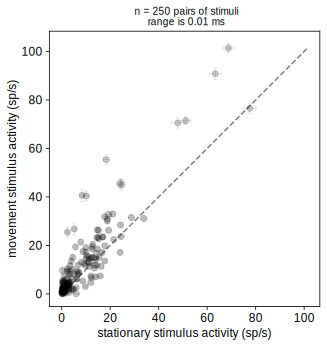

In [13]:
data = trial_ts.copy()

stims_offset_df = calculate_stim_offsets(data, trial_start_col='center_port_entries')
matched_unique_pairs_df = find_unique_cross_trial_offset_pairs(stims_offset_df, wiggle_room=0.010)

range = np.round(matched_unique_pairs_df.offset_diff.max() - matched_unique_pairs_df.offset_diff.min(), 2)
# Extract alignment times for the matched pairs
stat_alignment_times = matched_unique_pairs_df['stat_stim_time'].values
move_alignment_times = matched_unique_pairs_df['move_stim_time'].values

# Define PETH parameters (adjust as needed, matching your previous analysis)
pre_seconds = 0.025
post_seconds = 0.15
binwidth_ms = 25
stim_window_start = 0.04
stim_window_end = 0.1

# Calculate PETH for stationary stimuli in the pairs
pop_peth_stat_matched, timebin_edges_stat, _ = population_peth(
    all_spike_times=spike_times_per_unit,
    alignment_times=stat_alignment_times,
    pre_seconds=pre_seconds,
    post_seconds=post_seconds,
    binwidth_ms=binwidth_ms,
    pad=0,
    kernel=None,
)

# Calculate PETH for movement stimuli in the pairs
pop_peth_move_matched, timebin_edges_move, _ = population_peth(
    all_spike_times=spike_times_per_unit,
    alignment_times=move_alignment_times,
    pre_seconds=pre_seconds,
    post_seconds=post_seconds,
    binwidth_ms=binwidth_ms,
    pad=0,
    kernel=None,
)

# Define the stimulus response window
stimulus_window_bool = (timebin_edges_stat[:-1] >= stim_window_start) & (timebin_edges_stat[:-1] <= stim_window_end)

# Calculate mean response per neuron across the matched pairs
# Shape of pop_peth is (n_neurons, n_trials/pairs, n_bins)
stat_response_per_neuron = np.mean(pop_peth_stat_matched[:, :, stimulus_window_bool], axis=(1, 2))
move_response_per_neuron = np.mean(pop_peth_move_matched[:, :, stimulus_window_bool], axis=(1, 2))

# Calculate SEM per neuron across the matched pairs
n_pairs = pop_peth_stat_matched.shape[1]
stat_sem_per_neuron = np.std(np.mean(pop_peth_stat_matched[:, :, stimulus_window_bool], axis=2), axis=1) / np.sqrt(n_pairs)
move_sem_per_neuron = np.std(np.mean(pop_peth_move_matched[:, :, stimulus_window_bool], axis=2), axis=1) / np.sqrt(n_pairs)

# --- Plotting ---
save_dir = '/Users/gabriel/Library/CloudStorage/GoogleDrive-grojasbowe@gmail.com/My Drive/UCLA/ChurchlandLab/lab_meetings/20250417/figures'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

plot_scatter_panel(ax, 
                    stat_response_per_neuron, 
                    move_response_per_neuron,
                    "stationary stimulus activity (sp/s)", 
                    "movement stimulus activity (sp/s)",
                    x_err=stat_sem_per_neuron, 
                    y_err=move_sem_per_neuron)

ax.set_title(f'n = {n_pairs} pairs of stimuli\nrange is {range} ms', fontsize=10)
plt.tight_layout()
# plt.savefig(pjoin(save_dir, f"matched_scatters_{range}s_offset.svg"), format='svg', dpi=300, bbox_inches='tight')
plt.show()

In [18]:
np.arange(n_neurons)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176])

Found 70 unique cross-trial pairs with offset difference <= 0.01s.
Found 53 unique cross-trial pairs with offset difference <= 0.01s.


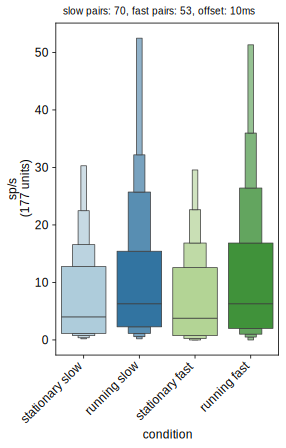

In [ ]:
# Define PETH parameters (matching your previous analysis)
pre_seconds = 0.025
post_seconds = 0.15
binwidth_ms = 25
stim_window_start = 0.04
stim_window_end = 0.1
wiggle = 0.010 # wiggle room for matching pairs in seconds

def compute_stim_response_for_trial_subset(trial_subset, 
                                           pre_seconds,
                                           post_seconds,
                                           binwith_ms,
                                           stim_window_start,
                                           sitm_window_end,
                                           wiggle_room=0.010):
    """
    Given a trial subset (slow or fast RT), compute the mean population response
    for stationary and movement conditions using matched unique pairs.
    Returns a dict with keys 'Stationary' and 'Movement'.
    """
    data = trial_subset.copy()
    stims_offset_df = calculate_stim_offsets(data, trial_start_col='center_port_entries')
    matched_pairs_df = find_unique_cross_trial_offset_pairs(stims_offset_df, wiggle_room=wiggle_room)
    if matched_pairs_df.empty:
        print("No matched pairs found!")
        return None
    
    # Alignment times for stationary and movement stims
    stat_alignment_times = matched_pairs_df['stat_stim_time'].values
    move_alignment_times = matched_pairs_df['move_stim_time'].values
    
    pop_peth_stat, timebin_edges_stat, _ = population_peth(
        all_spike_times=spike_times_per_unit,
        alignment_times=stat_alignment_times,
        pre_seconds=pre_seconds,
        post_seconds=post_seconds,
        binwidth_ms=binwidth_ms,
        pad=0,
        kernel=None,
    )
    pop_peth_move, timebin_edges_move, _ = population_peth(
        all_spike_times=spike_times_per_unit,
        alignment_times=move_alignment_times,
        pre_seconds=pre_seconds,
        post_seconds=post_seconds,
        binwidth_ms=binwidth_ms,
        pad=0,
        kernel=None,
    )
    
    # Define response window based on timebins (use stationary timebins as reference)
    stimulus_window_bool = (timebin_edges_stat[:-1] >= stim_window_start) & (timebin_edges_stat[:-1] <= stim_window_end)
    
    # Compute per-unit mean response averaged across matched pairs and within stimulus window
    stat_response = np.mean(pop_peth_stat[:, :, stimulus_window_bool], axis=(1,2))
    move_response = np.mean(pop_peth_move[:, :, stimulus_window_bool], axis=(1,2))
    return {"Stationary": stat_response, "Movement": move_response}, len(matched_pairs_df)

slow_rt_trial_ts = trial_ts[trial_ts.index.isin(trials_idx_75)].copy()
fast_rt_trial_ts = trial_ts[trial_ts.index.isin(trials_idx_25)].copy()

slow_responses, n_slow_pairs = compute_condition_response(slow_rt_trial_ts, wiggle_room=wiggle)
fast_responses, n_fast_pairs = compute_condition_response(fast_rt_trial_ts, wiggle_room=wiggle)

n_neurons = slow_responses["Stationary"].shape[0]
rows = []
for neuron in np.arange(n_neurons):
    rows.append({
        "neuron_id": neuron,
        "activity": slow_responses["Stationary"][neuron],
        "condition": "stationary slow"
    })
    rows.append({
        "neuron_id": neuron,
        "activity": slow_responses["Movement"][neuron],
        "condition": "running slow"
    })
    rows.append({
        "neuron_id": neuron,
        "activity": fast_responses["Stationary"][neuron],
        "condition": "stationary fast"
    })
    rows.append({
        "neuron_id": neuron,
        "activity": fast_responses["Movement"][neuron],
        "condition": "running fast"
    })
    
results_df = pd.DataFrame(rows)

# Create a violin plot showing activity distributions across the 4 conditions
condition_order = [
    "stationary slow", 
    "running slow",
    "stationary fast", 
    "running fast"
]

plt.figure(figsize=(4, 6))
# sns.catplot(data=results_df, x='condition', y='activity', order=condition_order,
#              hue='condition', palette="Paired", saturation=0.75, showfliers=True,
#              kind='boxen', width_method="exponential", k_depth="trustworthy", trust_alpha=0.01)
sns.boxenplot(data=results_df, x='condition', y='activity', order=condition_order, 
              hue='condition', palette="Paired", saturation=0.75, showfliers=False,
              width_method="exponential", k_depth="trustworthy", trust_alpha=0.01)
plt.ylabel(f'sp/s\n({int(results_df.shape[0]/4)} units)')
plt.xticks(rotation=45, ha='right')
# Add legend with trial counts
# n_stat_slow = len(slow_rt_trial_ts)
# n_stat_fast = len(fast_rt_trial_ts)
# legend_labels = [
#     f"stationary slow (n={n_stat_slow})",
#     f"running slow (n={n_stat_slow})",
#     f"stationary fast (n={n_stat_fast})",
#     f"running fast (n={n_stat_fast})"
# ]
# plt.legend(legend_labels, title="condition", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.figtext(0.15, 0.90, f"slow pairs: {n_slow_pairs}, fast pairs: {n_fast_pairs}, offset: {wiggle*1000:.0f}ms", fontsize=10)
# plt.tight_layout()
plt.show()

In [ ]:
import itertools
from scipy.stats import ttest_rel, wilcoxon
import numpy as np

# Define the condition order
pivot_df = results_df.pivot(index='neuron_id', columns='condition', values='activity')
# Enforce the condition order 
condition_order = ["stationary slow", "running slow", "stationary fast", "running fast"]
pivot_df = pivot_df[condition_order]
comparisons = list(itertools.combinations(condition_order, 2))

### Parametric test: Pairwise paired t-tests ###
print("Pairwise paired t-tests with Bonferroni corrections:")
t_results = []
for cond1, cond2 in comparisons:
    t_stat, p_val = ttest_rel(pivot_df[cond1], pivot_df[cond2])
    t_results.append((cond1, cond2, t_stat, p_val))
    
# Apply Bonferroni correction for multiple comparisons
alpha = 0.05
bonferroni_alpha = alpha / len(comparisons)
for cond1, cond2, t_stat, p_val in t_results:
    signif = "SIGNIFICANT" if p_val < bonferroni_alpha else "NS"
    print(f"{cond1} vs {cond2}: t={t_stat:.3f}, p={p_val:.3f} ({signif}, threshold={bonferroni_alpha:.3f})")

### Non-parametric test: Pairwise Wilcoxon signed-rank tests ###
print("\nPairwise Wilcoxon signed-rank tests with Bonferroni corrections:")
w_results = []
for cond1, cond2 in comparisons:
    try:
        w_stat, p_val = wilcoxon(pivot_df[cond1], pivot_df[cond2])
        w_results.append((cond1, cond2, w_stat, p_val))
    except Exception as e:
        print(f"Error comparing {cond1} vs {cond2}: {e}")

# Apply Bonferroni correction
for cond1, cond2, w_stat, p_val in w_results:
    signif = "SIGNIFICANT" if p_val < bonferroni_alpha else "NS"
    print(f"{cond1} vs {cond2}: W={w_stat:.3f}, p={p_val:.3f} ({signif}, threshold={bonferroni_alpha:.3f})")

Pairwise paired t-tests with Bonferroni corrections:
stationary slow vs running slow: t=-7.069, p=0.000 (SIGNIFICANT, threshold=0.008)
stationary slow vs stationary fast: t=2.628, p=0.009 (NS, threshold=0.008)
stationary slow vs running fast: t=-6.487, p=0.000 (SIGNIFICANT, threshold=0.008)
running slow vs stationary fast: t=7.135, p=0.000 (SIGNIFICANT, threshold=0.008)
running slow vs running fast: t=-1.238, p=0.217 (NS, threshold=0.008)
stationary fast vs running fast: t=-6.877, p=0.000 (SIGNIFICANT, threshold=0.008)

Pairwise Wilcoxon signed-rank tests with Bonferroni corrections:
stationary slow vs running slow: W=2509.000, p=0.000 (SIGNIFICANT, threshold=0.008)
stationary slow vs stationary fast: W=5471.000, p=0.001 (SIGNIFICANT, threshold=0.008)
stationary slow vs running fast: W=3369.000, p=0.000 (SIGNIFICANT, threshold=0.008)
running slow vs stationary fast: W=2625.000, p=0.000 (SIGNIFICANT, threshold=0.008)
running slow vs running fast: W=7008.000, p=0.303 (NS, threshold=0.008